### V7: Fine-Tune DistilBERT 
- Train Data
- Stride 64
- Down Sampling 'O' Label 0.30
- External Dataset
- Evaluation Metric F-Beta5
- Cross Validation

Trained on local machine with RTX 3050 x1

Leaderboard 
- Public Score: 0.892
- Private Score: 0.895

In [1]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import torch

from datasets import Dataset
from functools import partial
from seqeval.metrics import accuracy_score, classification_report
from transformers import AutoTokenizer
from transformers import DataCollatorForTokenClassification
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from tqdm import tqdm

In [2]:
class Setting:
    seed = 42
    
    # data
    data_train = "./data/pii-detection-removal-from-educational-data/train.json"
    data_nbroad = "./data/pii-dd-mistral-generated/mixtral-8x7b-v1.json"
    data_valentinwerner = "./data/pii-label-specific-data/all_labels.json"
    data_alejopaulier = "./data/fix-punctuation-tokenization-external-dataset/pii_dataset_fixed.json"
    data_pjmathematician = "./data/fix-punctuation-tokenization-external-dataset/moredata_dataset_fixed.json"
    data_minhsienweng = "./data/ai-generated-text-dataset/pii_dataset_Gemma.json"
    data_mandrilator = "./data/pii-mistral-2k-fit-competition-v2/all_labels.json"
    down_sample_ratio = 0.30
    n_split = 5
    
    # model
    model_checkpoint = "./model/distilbert/distilbert-base-uncased"
    model_train = './model/v7/train'
    model_final = './model/v7/final'
    max_length = 512
    stride = 64
    
    # hyperparameter
    epochs = 2
    learning_rate = 3e-5
    warmup_ratio = 0.1
    lr_scheduler_type='cosine'
    weight_decay = 0.01
    grad_steps = 2
    batch_size = 8
    
    # PII (NER) tags
    labels = ["B-EMAIL", "B-ID_NUM", "B-NAME_STUDENT", "B-PHONE_NUM",
              "B-STREET_ADDRESS", "B-URL_PERSONAL", "B-USERNAME",
              "I-ID_NUM", "I-NAME_STUDENT", "I-PHONE_NUM",
              "I-STREET_ADDRESS","I-URL_PERSONAL","O"]
    id2label = dict(enumerate(labels)) # integer label to BIO format label mapping
    label2id = {v:k for k,v in id2label.items()} # BIO format label to integer label mapping
    num_labels = len(labels) # number of PII (NER) tags

In [3]:
np.random.seed(Setting.seed)
torch.manual_seed(Setting.seed)

In [4]:
# read and combine all dataset
df_train = pd.read_json(Setting.data_train)
df_nbroad = pd.read_json(Setting.data_nbroad)
df_valentinwerner = pd.read_json(Setting.data_valentinwerner)
df_alejopaulier = pd.read_json(Setting.data_alejopaulier)
df_pjmathematician = pd.read_json(Setting.data_pjmathematician)
df_minhsienweng = pd.read_json(Setting.data_minhsienweng)
df_mandrilator = pd.read_json(Setting.data_mandrilator)

features = ['tokens', 'labels']
df = pd.concat([df_train[features], 
                   df_nbroad[features], 
                   df_valentinwerner[features], 
                   df_alejopaulier[features], 
                   df_pjmathematician[features],
                   df_minhsienweng[features],
                   df_mandrilator[features]],
                   ignore_index=True)

df = df[['tokens', 'labels']]
df.rename(columns={"labels": "pii_labels"}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27442 entries, 0 to 27441
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tokens      27442 non-null  object
 1   pii_labels  27442 non-null  object
dtypes: object(2)
memory usage: 428.9+ KB


In [5]:
def plot_bar_chart(data, target_column, title, xlabel, ylabel):
    target = data[target_column].value_counts(sort=False).reset_index(name='total')
    ax = sns.barplot(
        data=target,
        y='total',
        x=target_column, 
        hue=target_column,
        palette='cool',
        estimator=lambda x: sum(x)*100.00/target['total'].sum())
    plt.tight_layout()
    plt.xlabel(xlabel, fontdict={'weight': 'bold'})
    plt.ylabel(ylabel, fontdict={'weight': 'bold'})
    plt.title(title)
    plt.xticks(rotation=0)
    plt.tick_params(axis='both', which='major', labelsize=9)
    # show percentage on bar for first 3 bars
    for index, row in target.iterrows():
        y = row.total*100.00/target['total'].sum()
        ax.text(row.name, y + 0.15, f'{y:.2f}%', fontsize=9)        
    ax.get_legend().remove()
    plt.show()

def down_sample(df, down_sample_ratio, seed):
    df['non_pii_entity_only'] = df['pii_labels'].apply(lambda x: sum(label=='O' for label in x)==len(x))
    
    df_non_pii_entity_only = df[df['non_pii_entity_only']].sample(frac=down_sample_ratio, random_state=seed)
    df_with_pii_entity = df[~df['non_pii_entity_only']]
    df = pd.concat([df_with_pii_entity, df_non_pii_entity_only])
    
    plot_bar_chart(df, 'non_pii_entity_only', "% of Documents with Non-PII Entity ('O' Label) Only", "Non-PII Entity", "Percentage")
    print(df['non_pii_entity_only'].value_counts())
    
    df.drop(columns=['non_pii_entity_only'], inplace=True)
    return df

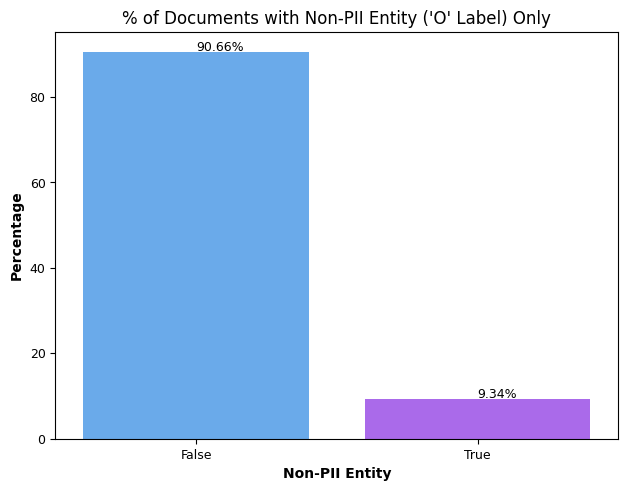

non_pii_entity_only
False    20430
True      2104
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 22534 entries, 0 to 23091
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tokens      22534 non-null  object
 1   pii_labels  22534 non-null  object
dtypes: object(2)
memory usage: 528.1+ KB


In [6]:
df = down_sample(df, Setting.down_sample_ratio, Setting.seed)
df.info()

In [7]:
ds = Dataset.from_pandas(df)
ds

Dataset({
    features: ['tokens', 'pii_labels', '__index_level_0__'],
    num_rows: 22534
})

In [8]:
def tokenize_and_align_labels(example, tokenizer, label2id, max_length, stride):
    tokenized_inputs = tokenizer(example["tokens"], 
                                 truncation=True,
                                 max_length=max_length,                                  
                                 stride=stride, 
                                 padding="max_length", 
                                 is_split_into_words=True,
                                 return_overflowing_tokens=True)
    tokenized_overflow_mappings = tokenized_inputs.overflow_to_sample_mapping
    labels = []
    #print(len(example["tokens"]), len(tokenized_overflow_mappings))
    for idx, overflow_mapping_id in enumerate(tokenized_overflow_mappings):
        label_ids = []
        previous_word_idx = None
        word_ids = tokenized_inputs.word_ids(batch_index=idx) # map tokens to their respective words
        label = example["pii_labels"]
        # using the overflow_mapping_id
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label2id[label[word_idx]])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [9]:
def rearrange_tokenized_input(dataset):
    # rearrange tokenized data to model input format
    tokenized = {   
        "input_ids": [],
        "labels": [],
        "attention_mask": [],       
    }
    #for i in tqdm(range(len(dataset))):
    for i in range(len(dataset)):
        doc = dataset[i]
        for j in range(len(doc["input_ids"])):
            tokenized["input_ids"].append(doc["input_ids"][j])
            tokenized["labels"].append(doc["labels"][j])
            tokenized["attention_mask"].append(doc["attention_mask"][j])
    return tokenized

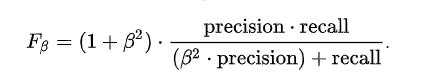
- The value of β is set to 5, which means that recall is weighted 5 times more heavily than precision.

In [10]:
def compute_metrics(p, id2label):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [id2label[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    
    report = classification_report(y_true=true_labels, y_pred=true_predictions, output_dict=True)
    micro_avg = report.pop("micro avg")    
    
    precision = micro_avg["precision"]
    recall = micro_avg["recall"]
    beta = 5
    fbeta = ((1+(beta**2))*precision*recall) / ((beta**2)*precision + recall)
    
    return {
        "precision": precision,
        "recall": recall,
        "f1": micro_avg["f1-score"],
        "fb-5": fbeta
    }

In [11]:
folds = [
    (
        np.array([i for i, d in enumerate(ds["pii_labels"]) if i % Setting.n_split != s]),
        np.array([i for i, d in enumerate(ds["pii_labels"]) if i % Setting.n_split == s])
    )
    for s in tqdm(range(Setting.n_split))
]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:30<00:00, 18.06s/it]


In [12]:
tokenizer = AutoTokenizer.from_pretrained(Setting.model_checkpoint)
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir=Setting.model_train,
    num_train_epochs=Setting.epochs,
    learning_rate=Setting.learning_rate,
    lr_scheduler_type=Setting.lr_scheduler_type,
    warmup_ratio=Setting.warmup_ratio,
    weight_decay=Setting.weight_decay,
    gradient_accumulation_steps=Setting.grad_steps,
    per_device_train_batch_size=Setting.batch_size,
    seed=Setting.seed,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="fb-5",
    greater_is_better=True,
    load_best_model_at_end=True
)

for fold_idx, (train_idx, val_idx) in enumerate(folds):        
    train_ds = ds.select(train_idx)
    val_ds = ds.select(val_idx)
    print(f'Fold: {fold_idx}, train_ds: {train_ds.num_rows}, val_ds:  {val_ds.num_rows}')    
    tokenized_train_ds = train_ds.map(tokenize_and_align_labels, 
                                         fn_kwargs={"tokenizer": tokenizer, 
                                                     "label2id": Setting.label2id, 
                                                     "max_length": Setting.max_length,
                                                     "stride": Setting.stride
                                                    }, 
                                         num_proc=os.cpu_count())    
    tokenized_train_ds = tokenized_train_ds.remove_columns(['tokens', 'pii_labels', 'overflow_to_sample_mapping'])    
    tokenized_train_ds = Dataset.from_dict(rearrange_tokenized_input(tokenized_train_ds))    
    tokenized_val_ds = val_ds.map(tokenize_and_align_labels, 
                                     fn_kwargs={"tokenizer": tokenizer, 
                                                 "label2id": Setting.label2id, 
                                                 "max_length": Setting.max_length,
                                                 "stride": Setting.stride
                                                }, 
                                     num_proc=os.cpu_count()) 
    tokenized_val_ds = tokenized_val_ds.remove_columns(['tokens', 'pii_labels', 'overflow_to_sample_mapping'])    
    tokenized_val_ds = Dataset.from_dict(rearrange_tokenized_input(tokenized_val_ds))
    print(f'Fold: {fold_idx}, tokenized_train_ds: {tokenized_train_ds.num_rows}, tokenized_val_ds:  {tokenized_val_ds.num_rows}') 
    
    model = AutoModelForTokenClassification.from_pretrained(
        Setting.model_checkpoint, 
        num_labels=Setting.num_labels, 
        id2label=Setting.id2label, 
        label2id=Setting.label2id
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train_ds,
        eval_dataset=tokenized_val_ds,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=partial(compute_metrics, id2label=Setting.id2label)
    )
    
    trainer.train()
    # set best model checkpoint
    Setting.model_checkpoint = trainer.state.best_model_checkpoint
    print(Setting.model_checkpoint)
    trainer.save_model(Setting.model_final)
    tokenizer.save_pretrained(Setting.model_final)

    del trainer
    gc.collect()
    torch.cuda.empty_cache()
    print('------------------------------------------------------')

Fold: 0, train_ds: 18027, val_ds:  4507


Map (num_proc=12):   0%|          | 0/18027 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/4507 [00:00<?, ? examples/s]

Fold: 0, tokenized_train_ds: 27580, tokenized_val_ds:  6887


Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at ./model/distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
D:\program\anaconda\envs\fws-dell\lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Fb-5
1,0.011800,0.009773,0.929751,0.874628,0.901347,0.876627
2,0.007400,0.008245,0.947409,0.876828,0.910753,0.879348


./model/v7/train\checkpoint-3448
------------------------------------------------------
Fold: 1, train_ds: 18027, val_ds:  4507


Map (num_proc=12):   0%|          | 0/18027 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/4507 [00:00<?, ? examples/s]

Fold: 1, tokenized_train_ds: 27549, tokenized_val_ds:  6918


D:\program\anaconda\envs\fws-dell\lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Fb-5
1,0.007700,0.006622,0.955132,0.884109,0.918249,0.886645
2,0.005400,0.006107,0.955504,0.893276,0.923343,0.895519


./model/v7/train\checkpoint-3444
------------------------------------------------------
Fold: 2, train_ds: 18027, val_ds:  4507


Map (num_proc=12):   0%|          | 0/18027 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/4507 [00:00<?, ? examples/s]

Fold: 2, tokenized_train_ds: 27619, tokenized_val_ds:  6848


D:\program\anaconda\envs\fws-dell\lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Fb-5
0,0.006500,0.005982,0.965053,0.891742,0.926950,0.894355
1,0.004100,0.004989,0.948063,0.920306,0.933978,0.921344


./model/v7/train\checkpoint-3452
------------------------------------------------------
Fold: 3, train_ds: 18027, val_ds:  4507


Map (num_proc=12):   0%|          | 0/18027 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/4507 [00:00<?, ? examples/s]

Fold: 3, tokenized_train_ds: 27597, tokenized_val_ds:  6870


D:\program\anaconda\envs\fws-dell\lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Fb-5
1,0.005000,0.004186,0.977066,0.906025,0.940205,0.908566
2,0.003000,0.003534,0.963959,0.948592,0.956213,0.949174


./model/v7/train\checkpoint-3450
------------------------------------------------------
Fold: 4, train_ds: 18028, val_ds:  4506


Map (num_proc=12):   0%|          | 0/18028 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/4506 [00:00<?, ? examples/s]

Fold: 4, tokenized_train_ds: 27523, tokenized_val_ds:  6944


D:\program\anaconda\envs\fws-dell\lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Fb-5
0,0.003900,0.002974,0.959678,0.960769,0.960223,0.960727
1,0.002000,0.002171,0.974016,0.966582,0.970285,0.966866


./model/v7/train\checkpoint-3440
------------------------------------------------------


In [12]:
Setting.epochs = 1
print(Setting.model_checkpoint)
print(Setting.epochs)

./model/distilbert/distilbert-base-uncased
1


In [15]:
training_args = TrainingArguments(
    output_dir=Setting.model_train,
    num_train_epochs=Setting.epochs,
    learning_rate=Setting.learning_rate,
    lr_scheduler_type=Setting.lr_scheduler_type,
    warmup_ratio=Setting.warmup_ratio,
    weight_decay=Setting.weight_decay,
    gradient_accumulation_steps=Setting.grad_steps,
    per_device_train_batch_size=Setting.batch_size,
    seed=Setting.seed,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="fb-5",
    greater_is_better=True,
    load_best_model_at_end=True
)

for fold_idx, (train_idx, val_idx) in enumerate(folds):        
    train_ds = ds.select(train_idx)
    val_ds = ds.select(val_idx)
    print(f'Fold: {fold_idx}, train_ds: {train_ds.num_rows}, val_ds:  {val_ds.num_rows}')    
    tokenized_train_ds = train_ds.map(tokenize_and_align_labels, 
                                         fn_kwargs={"tokenizer": tokenizer, 
                                                     "label2id": Setting.label2id, 
                                                     "max_length": Setting.max_length,
                                                     "stride": Setting.stride
                                                    }, 
                                         num_proc=os.cpu_count())    
    tokenized_train_ds = tokenized_train_ds.remove_columns(['tokens', 'pii_labels', 'overflow_to_sample_mapping'])    
    tokenized_train_ds = Dataset.from_dict(rearrange_tokenized_input(tokenized_train_ds))    
    tokenized_val_ds = val_ds.map(tokenize_and_align_labels, 
                                     fn_kwargs={"tokenizer": tokenizer, 
                                                 "label2id": Setting.label2id, 
                                                 "max_length": Setting.max_length,
                                                 "stride": Setting.stride
                                                }, 
                                     num_proc=os.cpu_count()) 
    tokenized_val_ds = tokenized_val_ds.remove_columns(['tokens', 'pii_labels', 'overflow_to_sample_mapping'])    
    tokenized_val_ds = Dataset.from_dict(rearrange_tokenized_input(tokenized_val_ds))
    print(f'Fold: {fold_idx}, tokenized_train_ds: {tokenized_train_ds.num_rows}, tokenized_val_ds:  {tokenized_val_ds.num_rows}') 
    
    model = AutoModelForTokenClassification.from_pretrained(
        Setting.model_checkpoint, 
        num_labels=Setting.num_labels, 
        id2label=Setting.id2label, 
        label2id=Setting.label2id
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train_ds,
        eval_dataset=tokenized_val_ds,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=partial(compute_metrics, id2label=Setting.id2label)
    )
    
    trainer.train()
    # set best model checkpoint
    Setting.model_checkpoint = trainer.state.best_model_checkpoint
    print(Setting.model_checkpoint)
    trainer.save_model(Setting.model_final)
    tokenizer.save_pretrained(Setting.model_final)

    del trainer
    gc.collect()
    torch.cuda.empty_cache()
    print('------------------------------------------------------')

Fold: 0, train_ds: 18027, val_ds:  4507


Map (num_proc=12):   0%|          | 0/18027 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/4507 [00:00<?, ? examples/s]

Fold: 0, tokenized_train_ds: 27580, tokenized_val_ds:  6887


D:\program\anaconda\envs\fws-dell\lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Fb-5
1,0.002500,0.001558,0.985338,0.980841,0.983084,0.981014


./model/v7/train\checkpoint-1724
------------------------------------------------------
Fold: 1, train_ds: 18027, val_ds:  4507


Map (num_proc=12):   0%|          | 0/18027 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/4507 [00:00<?, ? examples/s]

Fold: 1, tokenized_train_ds: 27549, tokenized_val_ds:  6918


D:\program\anaconda\envs\fws-dell\lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Fb-5
1,0.002100,0.001343,0.987118,0.978821,0.982952,0.979137


./model/v7/train\checkpoint-1722
------------------------------------------------------
Fold: 2, train_ds: 18027, val_ds:  4507


Map (num_proc=12):   0%|          | 0/18027 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/4507 [00:00<?, ? examples/s]

Fold: 2, tokenized_train_ds: 27619, tokenized_val_ds:  6848


D:\program\anaconda\envs\fws-dell\lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Fb-5
0,0.001700,0.001269,0.985808,0.984210,0.985009,0.984272


./model/v7/train\checkpoint-1726
------------------------------------------------------
Fold: 3, train_ds: 18027, val_ds:  4507


Map (num_proc=12):   0%|          | 0/18027 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/4507 [00:00<?, ? examples/s]

Fold: 3, tokenized_train_ds: 27597, tokenized_val_ds:  6870


D:\program\anaconda\envs\fws-dell\lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Fb-5
1,0.001300,0.001085,0.990164,0.986096,0.988126,0.986252


./model/v7/train\checkpoint-1725
------------------------------------------------------
Fold: 4, train_ds: 18028, val_ds:  4506


Map (num_proc=12):   0%|          | 0/18028 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/4506 [00:00<?, ? examples/s]

Fold: 4, tokenized_train_ds: 27523, tokenized_val_ds:  6944


D:\program\anaconda\envs\fws-dell\lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Fb-5
0,0.001100,0.000826,0.994880,0.990809,0.992841,0.990965


./model/v7/train\checkpoint-1720
------------------------------------------------------


In [12]:
Setting.epochs = 1
Setting.model_checkpoint = "./model/v7/train/checkpoint-1720"
print(Setting.model_checkpoint)
print(Setting.epochs)

./model/v7/train/checkpoint-1720
1


In [13]:
tokenizer = AutoTokenizer.from_pretrained(Setting.model_checkpoint)
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [14]:
training_args = TrainingArguments(
    output_dir=Setting.model_train,
    num_train_epochs=Setting.epochs,
    learning_rate=Setting.learning_rate,
    lr_scheduler_type=Setting.lr_scheduler_type,
    warmup_ratio=Setting.warmup_ratio,
    weight_decay=Setting.weight_decay,
    gradient_accumulation_steps=Setting.grad_steps,
    per_device_train_batch_size=Setting.batch_size,
    seed=Setting.seed,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="fb-5",
    greater_is_better=True,
    load_best_model_at_end=True
)

for fold_idx, (train_idx, val_idx) in enumerate(folds):        
    train_ds = ds.select(train_idx)
    val_ds = ds.select(val_idx)
    print(f'Fold: {fold_idx}, train_ds: {train_ds.num_rows}, val_ds:  {val_ds.num_rows}')    
    tokenized_train_ds = train_ds.map(tokenize_and_align_labels, 
                                         fn_kwargs={"tokenizer": tokenizer, 
                                                     "label2id": Setting.label2id, 
                                                     "max_length": Setting.max_length,
                                                     "stride": Setting.stride
                                                    }, 
                                         num_proc=os.cpu_count())    
    tokenized_train_ds = tokenized_train_ds.remove_columns(['tokens', 'pii_labels', 'overflow_to_sample_mapping'])    
    tokenized_train_ds = Dataset.from_dict(rearrange_tokenized_input(tokenized_train_ds))    
    tokenized_val_ds = val_ds.map(tokenize_and_align_labels, 
                                     fn_kwargs={"tokenizer": tokenizer, 
                                                 "label2id": Setting.label2id, 
                                                 "max_length": Setting.max_length,
                                                 "stride": Setting.stride
                                                }, 
                                     num_proc=os.cpu_count()) 
    tokenized_val_ds = tokenized_val_ds.remove_columns(['tokens', 'pii_labels', 'overflow_to_sample_mapping'])    
    tokenized_val_ds = Dataset.from_dict(rearrange_tokenized_input(tokenized_val_ds))
    print(f'Fold: {fold_idx}, tokenized_train_ds: {tokenized_train_ds.num_rows}, tokenized_val_ds:  {tokenized_val_ds.num_rows}') 
    
    model = AutoModelForTokenClassification.from_pretrained(
        Setting.model_checkpoint, 
        num_labels=Setting.num_labels, 
        id2label=Setting.id2label, 
        label2id=Setting.label2id
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train_ds,
        eval_dataset=tokenized_val_ds,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=partial(compute_metrics, id2label=Setting.id2label)
    )
    
    trainer.train()
    # set best model checkpoint
    Setting.model_checkpoint = trainer.state.best_model_checkpoint
    print(Setting.model_checkpoint)
    trainer.save_model(Setting.model_final)
    tokenizer.save_pretrained(Setting.model_final)

    del trainer
    gc.collect()
    torch.cuda.empty_cache()
    print('------------------------------------------------------')

Fold: 0, train_ds: 18027, val_ds:  4507


Map (num_proc=12):   0%|          | 0/18027 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/4507 [00:00<?, ? examples/s]

Fold: 0, tokenized_train_ds: 27580, tokenized_val_ds:  6887


D:\program\anaconda\envs\fws-dell\lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Fb-5
1,0.001300,0.000718,0.993008,0.992751,0.992879,0.992761


./model/v7/train\checkpoint-1724
------------------------------------------------------
Fold: 1, train_ds: 18027, val_ds:  4507


Map (num_proc=12):   0%|          | 0/18027 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/4507 [00:00<?, ? examples/s]

Fold: 1, tokenized_train_ds: 27549, tokenized_val_ds:  6918


D:\program\anaconda\envs\fws-dell\lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Fb-5
1,0.001200,0.000662,0.992477,0.991032,0.991754,0.991087


./model/v7/train\checkpoint-1722
------------------------------------------------------
Fold: 2, train_ds: 18027, val_ds:  4507


Map (num_proc=12):   0%|          | 0/18027 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/4507 [00:00<?, ? examples/s]

Fold: 2, tokenized_train_ds: 27619, tokenized_val_ds:  6848


D:\program\anaconda\envs\fws-dell\lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Fb-5
0,0.001100,0.001009,0.990904,0.989009,0.989956,0.989082


./model/v7/train\checkpoint-1726
------------------------------------------------------
Fold: 3, train_ds: 18027, val_ds:  4507


Map (num_proc=12):   0%|          | 0/18027 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/4507 [00:00<?, ? examples/s]

Fold: 3, tokenized_train_ds: 27597, tokenized_val_ds:  6870


D:\program\anaconda\envs\fws-dell\lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Fb-5
1,0.000900,0.000550,0.992351,0.993590,0.992970,0.993543


./model/v7/train\checkpoint-1725
------------------------------------------------------
Fold: 4, train_ds: 18028, val_ds:  4506


Map (num_proc=12):   0%|          | 0/18028 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/4506 [00:00<?, ? examples/s]

Fold: 4, tokenized_train_ds: 27523, tokenized_val_ds:  6944


D:\program\anaconda\envs\fws-dell\lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Fb-5
0,0.000700,0.000675,0.993854,0.992563,0.993208,0.992613


./model/v7/train\checkpoint-1720
------------------------------------------------------
